In [ ]:
# !pip uninstall tensorflow
# !pip install tensorflow==2.1.0
# !pip install --upgrade gensim --user
# # tf.compat.v1.disable_v2_behavior()
# !pip install -q pyyaml h5py  # Required to save models in HDF5 format
# !pip install np_utils
# !pip install --upgrade --user keras
# import nltk
# nltk.download('punkt')
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()

2.1.0


'/device:GPU:0'

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
import pandas as pd
import json
import os
import glob
import pickle
#from os import path
# import malaya

In [4]:
df_allnews_unpickled = pd.read_pickle("./malaya_fake_news_preprocessed_dataframe.pkl")        #Load FakeNews Dataset from your path
df_allnews_unpickled

,news,tokens,rejoined,length,label,real,fake
0,demi lovato telah jujur kejam tentang pertempu...,"[demi, lovato, telah, jujur, kejam, tentang, p...",demi lovato telah jujur kejam tentang pertempu...,448,1,1,0
1,selamat pagi inilah yang perlu anda ketahui se...,"[selamat, pagi, inilah, yang, perlu, anda, ket...",selamat pagi inilah yang perlu anda ketahui se...,682,1,1,0
2,tahniah untuk bintang glee lea michele pelakon...,"[tahniah, untuk, bintang, glee, lea, michele, ...",tahniah untuk bintang glee lea michele pelakon...,247,1,1,0
3,ia adalah satu kejutan yang mengejutkan untuk ...,"[ia, adalah, satu, kejutan, yang, mengejutkan,...",ia adalah satu kejutan yang mengejutkan untuk ...,718,1,1,0
4,transkrip minggu ini dengan george stephanopou...,"[transkrip, minggu, ini, dengan, george, steph...",transkrip minggu ini dengan george stephanopou...,668,1,1,0
...,...,...,...,...,...,...,...
37587,katie holmes tidak mengandung anak jamie foxx ...,"[katie, holmes, tidak, mengandung, anak, jamie...",katie holmes tidak mengandung anak jamie foxx ...,336,0,0,1
37588,donald trump menegaskan bahawa serangan siber ...,"[donald, trump, menegaskan, bahawa, serangan, ...",donald trump menegaskan bahawa serangan siber ...,248,1,1,0
37589,ia bukan cerita pertama yang bermula dengan pe...,"[ia, bukan, cerita, pertama, yang, bermula, de...",ia bukan cerita pertama yang bermula dengan pe...,663,1,1,0
37590,presiden donald trump mengumumkan bahawa dia t...,"[presiden, donald, trump, mengumumkan, bahawa,...",presiden donald trump mengumumkan bahawa dia t...,100,1,1,0


In [5]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import tensorflow as tf
from __future__ import division, print_function
import gensim
from gensim import models
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding, Bidirectional, LSTM, Lambda
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
# from keras.layers.recurrent import LSTM
# from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np

# demonstration of calculating metrics for a neural network model using sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

Build vocabulary for all the words inside the dataframe

In [6]:
all_words = [word for tokens in df_allnews_unpickled["tokens"] for word in tokens]
all_sentence_lengths = [len(tokens) for tokens in df_allnews_unpickled["tokens"]]
ave_sentence_lengths = sum(all_sentence_lengths)/len(all_sentence_lengths)
ALL_VOCAB = sorted(list(set(all_words)))

print("%s words total, with a vocabulary size of %s" % (len(all_words), len(ALL_VOCAB)))
print("Max sentence length is %s" % max(all_sentence_lengths))
print("Average sentence length is %s" % ave_sentence_lengths)

16195904 words total, with a vocabulary size of 186872
Max sentence length is 991
Average sentence length is 430.8337944243456


Load Word2Vec Model

In [7]:
from gensim.models.callbacks import CallbackAny2Vec

loss_list = list()

# # This function is only redefined because the Malay Word2Vec is trained with this function
# # For some reason, gensim could not Word2Vec without this function
# # Not used in this Notebook
class LossLogger(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subbed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subbed
        loss_list.append(loss_now)
        self.loss_to_be_subbed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

In [8]:
word2vec_path = './mswiki.model'
# word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
# word2vec = gensim.models.KeyedVectors.load(word2vec_path)
word2vec = gensim.models.Word2Vec.load(word2vec_path)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Convert list (of words) into sequences (of int) based on the vocabulary list.
<br> Add reserved indices at the beginning of the converted sequence.

In [9]:
tokenizer = Tokenizer(num_words=len(ALL_VOCAB), lower=True, char_level=False, oov_token='<UNK>')
tokenizer.fit_on_texts(df_allnews_unpickled["tokens"].tolist())
sequences_all = tokenizer.texts_to_sequences(df_allnews_unpickled["tokens"].tolist())

for i in range(len(sequences_all)):
  for j in range(len(sequences_all[i])):
    sequences_all[i][j] += 2         # # The first 4 [0,1,2,3] indices are reserved
sequences_all = [[1] + sub for sub in sequences_all]    #at <START> tag at the beginning of all subitems

all_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(all_word_index))


# # The first 4 [0,1,2,3] indices are reserved
# all_word_index = {k:(v+2) for k,v in all_word_index.items()}
for key, value in all_word_index.items():
  all_word_index[key] += 2
all_word_index["<PAD>"] = 0
all_word_index["<START>"] = 1
all_word_index["<UNUSED>"] = 2
all_word_index["<UNK>"] = 3  # unknown

Found 186873 unique tokens.


In [10]:
all_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(all_word_index))

Found 186876 unique tokens.


Define function(s) to decode sequences back to text

In [11]:
reverse_word_index = dict([(value, key) for (key, value) in all_word_index.items()])
def decode_news(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [12]:
# MAX_SEQUENCE_LENGTH = 50
# MAX_SEQUENCE_LENGTH = 128
MAX_SEQUENCE_LENGTH = max(all_sentence_lengths)
EMBEDDING_DIM = 300
print (MAX_SEQUENCE_LENGTH)
print (EMBEDDING_DIM)

991
300


Pad the sequence by MAX_SEQUENCE_LENGTH

In [13]:
# train_rcnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)
all_data = pad_sequences(sequences_all, value=all_word_index["<PAD>"], padding='post', truncating='post', maxlen=MAX_SEQUENCE_LENGTH)

Initialize Embedding Layer weights based on Word2Vec values.
<br> The embedding will be initialized randomly for words that does not exist in Word2Vec model.

In [14]:
count_vpre = 0

embedding_weights = np.zeros((len(all_word_index), EMBEDDING_DIM))
for word,index in all_word_index.items():
  # embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
  if word in word2vec:
    embedding_weights[index,:] = word2vec[word]
    count_vpre += 1
  else:
    # embedding_weights[index,:] = np.random.RandomState(3435).rand(EMBEDDING_DIM)
    embedding_weights[index,:] = (0.5*np.random.RandomState(3435).rand(EMBEDDING_DIM)) - 0.25     #Initialize unknown vector between [-0.25, 0.25]


print(embedding_weights.shape)
print("Number of words present in the set of pre-trained word vectors %s" % count_vpre)

(186876, 300)
Number of words present in the set of pre-trained word vectors 60562


In [ ]:
idx = 8

for key, value in all_word_index.items():
  if value == idx:
    print(key, value)

print(embedding_weights[idx])

In [ ]:
label_names = ['real', 'fake']
labels_list = df_allnews_unpickled[label_names].values
# print (labels_list[42])
# print (sequences_all[42])
# # Zip back the news and labels into a temporary list
all_newsnlabels = list(zip(all_data, labels_list))
# print (all_newsnlabels[42][0])
# print (all_newsnlabels[42][1])

In [ ]:
l2_rate = 1e-3
dropout_rate = 0.5
n_filter = 300
filter_size = 3
lr_rate = 5e-4
# print (str(lr_rate))

Define RCNN Architecture

In [ ]:
def RCNN(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    hidden_dim_1 = 200
    hidden_dim_2 = 100

    embedder = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            trainable=False)      #input_length=max_sequence_length,
    
    # sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    # embedded_sequences = embedding_layer(sequence_input)

    #TODO
    document = Input(shape = (None, ), dtype = "int32")
    left_context = Input(shape = (None, ), dtype = "int32")
    right_context = Input(shape = (None, ), dtype = "int32")

    # embedder = Embedding(MAX_TOKENS + 1, embedding_dim, weights = [embeddings], trainable = False)
    doc_embedding = embedder(document)
    l_embedding = embedder(left_context)
    r_embedding = embedder(right_context)

    forward = LSTM(hidden_dim_1, return_sequences = True)(l_embedding)
    backward = LSTM(hidden_dim_1, return_sequences = True, go_backwards = True)(r_embedding)
    # Reverse back the backward propagated layer.
    backward = Lambda(lambda x: K.reverse(x, axes=1))(backward)
    together = concatenate([forward, doc_embedding, backward], axis=2)

    semantic = Conv1D(hidden_dim_2, kernel_size=1, activation="tanh")(together)

    #Manual max-pooling layer
    pool_rnn = Lambda(lambda x: K.max(x, axis=1), output_shape=(hidden_dim_2, ))(semantic)

    output = Dense(labels_index, input_dim=hidden_dim_2, activation="softmax")(pool_rnn)

    model = Model(inputs=[left_context, document, right_context], outputs=output)
    model.compile(loss="binary_crossentropy", optimizer = "adam", metrics=["accuracy"])
    #TODO 
    
    model.summary()
    return model

In [ ]:
model = RCNN(embedding_weights, MAX_SEQUENCE_LENGTH, len(all_word_index), 
                EMBEDDING_DIM, len(list(label_names)))

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 300)    57945300    input_1[0][0]                    
                                                                 input_2[0][0]                

In [ ]:
model.save_weights('./rcnn/rcnn_model_10fold.h5')

In [ ]:
model.load_weights('./rcnn/rcnn_model_10fold.h5')

In [ ]:
weights = []
for layer in model.layers:
    weights.append(layer.get_weights()) # list of numpy arrays

print ((weights[5][0]))

[[ 3.6745608e-02 -5.7440400e-02 -7.3520936e-02 ... -5.2801371e-03
  -6.0744118e-02 -7.2360151e-02]
 [-3.3982098e-05 -2.2173088e-02 -1.6057733e-02 ... -2.2326913e-02
  -6.5743700e-03 -4.8572589e-02]
 [-5.8293268e-03 -1.8092047e-02  3.9364234e-02 ...  1.0002986e-02
   5.8238924e-02 -3.5897937e-02]
 ...
 [-3.3321515e-02  6.3335165e-02 -5.3264044e-02 ... -1.8107329e-02
  -9.3199760e-03 -2.8667197e-02]
 [-5.1766276e-02  5.1034607e-02  8.0411881e-04 ... -1.6896877e-02
   2.0124808e-02 -5.2866410e-02]
 [ 3.5278261e-02 -6.3270584e-02  1.6442105e-02 ... -5.9252739e-02
   4.3316469e-02 -2.3006983e-02]]


K-fold Cross Validation stars here

In [ ]:
num_folds = 10
num_epochs = 2    
batch_size = 50
fold_no = 1
kfold = KFold(n_splits=num_folds, shuffle=False)

In [ ]:
# data_train, data_test = train_test_split(all_newsnlabels, test_size=0.10, random_state=42)
inputs = all_data
targets = labels_list
print (len(inputs))
print (len(targets))

arr_id = np.asarray(df_allnews_unpickled.index)
print (len(arr_id))

# x_train = np.asarray([row[0] for row in data_train])
# y_train = np.asarray([row[1] for row in data_train])
# x_test = np.asarray([row[0] for row in data_test])
# y_test = np.asarray([row[1] for row in data_test])
# print (x_train[42])
# print (y_train[42])
# print (inputs[39505])
# print (targets[39505])

39486
39486
39486


In [ ]:
fold_no = 1
results_history = []

acc_per_fold = []
loss_per_fold = []

# # Lists for metrics result
all_accuracy = []
all_precision = []
all_recall = []
all_f1 = []

# # Lists for plotting Precision-Recall Curve
all_arr_precision = []
all_arr_recall = []
all_thresholds = []
all_ave_precision = []

# # Lists for Confusion Matrices
all_cf_matrices = []

# # Lists for Noise Data
all_wrong = []

for train, test in kfold.split(inputs, targets):
  model.load_weights('./rcnn/rcnn_model_10fold.h5')     #Load the same initial weights for all splits
  x_train = np.asarray(inputs[train])
  y_train = np.asarray(targets[train])
  x_test = np.asarray(inputs[test])
  y_test = np.asarray(targets[test])

  temp_arr_id = np.asarray(arr_id[test])

  # Shift by adding <UNUSED> tokens
  # We shift the document to the right to obtain the left-side contexts.
  x_train_left = [[2] + row for row in x_train.tolist()]
  x_train_left = np.asarray([row[:-1] for row in x_train_left])
  # We shift the document to the left to obtain the right-side contexts.
  x_train_right = [row + [2] for row in x_train.tolist()]
  x_train_right = np.asarray([row[1:] for row in x_train_right])

  x_test_left = [[2] + row for row in x_test.tolist()]
  x_test_left = np.asarray([row[:-1] for row in x_test_left])

  x_test_right = [row + [2] for row in x_test.tolist()]
  x_test_right = np.asarray([row[1:] for row in x_test_right])
  
  # # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  
  checkpoint_path = "./rcnn/rcnn_training_10fold/cp_10fold_{}.ckpt".format(fold_no)
  # Create a callback that saves the model's weights
  cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
  
  hist = model.fit([x_train_left, x_train, x_train_right], y_train, epochs=num_epochs, validation_data=([x_test_left, x_test, x_test_right],y_test),     #validation_split = 0.1, 
                 shuffle=True, batch_size=batch_size, callbacks=None)    #callbacks=[cp_callback]
  
  # results_history.append(hist)
  results_history.append(hist.history)

  #EVALUATE MODEL ON TEST SET
  results_scores = model.evaluate([x_test_left, x_test, x_test_right], y_test)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {results_scores[0]}; {model.metrics_names[1]} of {results_scores[1]*100}%')
  acc_per_fold.append(results_scores[1] * 100)
  loss_per_fold.append(results_scores[0])


  # METRICS CALCULATION STARTS HERE
  # predict probabilities for test set
  yhat_probs = model.predict([x_test_left, x_test, x_test_right], verbose=0)
  # y_probs = np.max(yhat_probs, axis=1)  #Predicted Probabilities
  y_probs = yhat_probs[:, 0] #Predicted Probabilities     #Consider only positive-predicted class for Precision Recall Curve
  
  # predict crisp classes for test set
  ## supposed use argmax but index of labels are arranged as [real, fake] = [0, 1]
  ## argmin is used to invert and get [1, 0] instead
  yhat_classes = yhat_probs.argmin(axis=-1)   #Predicted Classes
  y_test_conv = y_test.argmin(axis=-1)        #Actual Classes

  for m in range(len(yhat_classes)):
    if (yhat_classes[m] != y_test_conv[m]):
      all_wrong.append(temp_arr_id[m])
    
  
  ## Metrics calculation
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(y_test_conv, yhat_classes)
  all_accuracy.append(accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(y_test_conv, yhat_classes)
  all_precision.append(precision)
  # recall: tp / (tp + fn)
  recall = recall_score(y_test_conv, yhat_classes)
  all_recall.append(recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y_test_conv, yhat_classes)
  all_f1.append(f1)

  ## Precision-Curve calculation
  arr_precision, arr_recall, thresholds = precision_recall_curve(y_test_conv, y_probs)
  thresholds = np.concatenate([thresholds,[thresholds[thresholds.size-1]]])
  all_arr_precision.append(arr_precision)
  all_arr_recall.append(arr_recall)
  all_thresholds.append(thresholds)

  ave_precision = average_precision_score(y_test_conv, y_probs)
  all_ave_precision.append(ave_precision)

  ## Confusion Matrix calculation
  cf_matrix = confusion_matrix(y_test_conv, yhat_classes)
  all_cf_matrices.append(cf_matrix)

  # Increase fold number
  fold_no = fold_no + 1
####################################

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')



# # Save history object as a file
with open('./rcnn/RCNNTrainHistoryDict_10fold', 'wb') as file_pi:
    pickle.dump(results_history, file_pi)
    # pickle.dump(hist.history, file_pi)
# hist = pickle.load(open('./rcnn/RCNNTrainHistoryDict_10fold', "rb"))

# # Create Dataframe to save all Metrics Result
df_allmetrics_10fold = pd.DataFrame(acc_per_fold)
df_allmetrics_10fold.columns = ['acc_per_fold']
df_allmetrics_10fold['loss_per_fold'] = loss_per_fold

df_allmetrics_10fold['all_accuracy'] = all_accuracy
df_allmetrics_10fold['all_precision'] = all_precision
df_allmetrics_10fold['all_recall'] = all_recall
df_allmetrics_10fold['all_f1'] = all_f1

df_allmetrics_10fold['all_arr_precision'] = all_arr_precision
df_allmetrics_10fold['all_arr_recall'] = all_arr_recall
df_allmetrics_10fold['all_thresholds'] = all_thresholds
df_allmetrics_10fold['all_ave_precision'] = all_ave_precision

df_allmetrics_10fold['all_cf_matrices'] = all_cf_matrices

df_allmetrics_10fold.to_pickle("./rcnn/rcnn_all_metrics_10fold.pkl")
# df_allmetrics_10fold

# # Create Dataframe to save all wrongly predicted index
df_indices = pd.DataFrame(all_wrong)
df_indices.columns = ['indices']
df_indices.to_pickle("./rcnn/rcnn_indices_wrong.pkl")

In [ ]:
#TODO: Determine history for each fold

# history_dict = hist.history
# history_dict = results_history[0]
# # history_dict = hist
# history_dict.keys()

Plot Loss and Accuracy for each Fold between Training and Validation for each epoch.


In [ ]:
df_indices =  pd.read_pickle("./rcnn/rcnn_indices_wrong.pkl")
df_indices

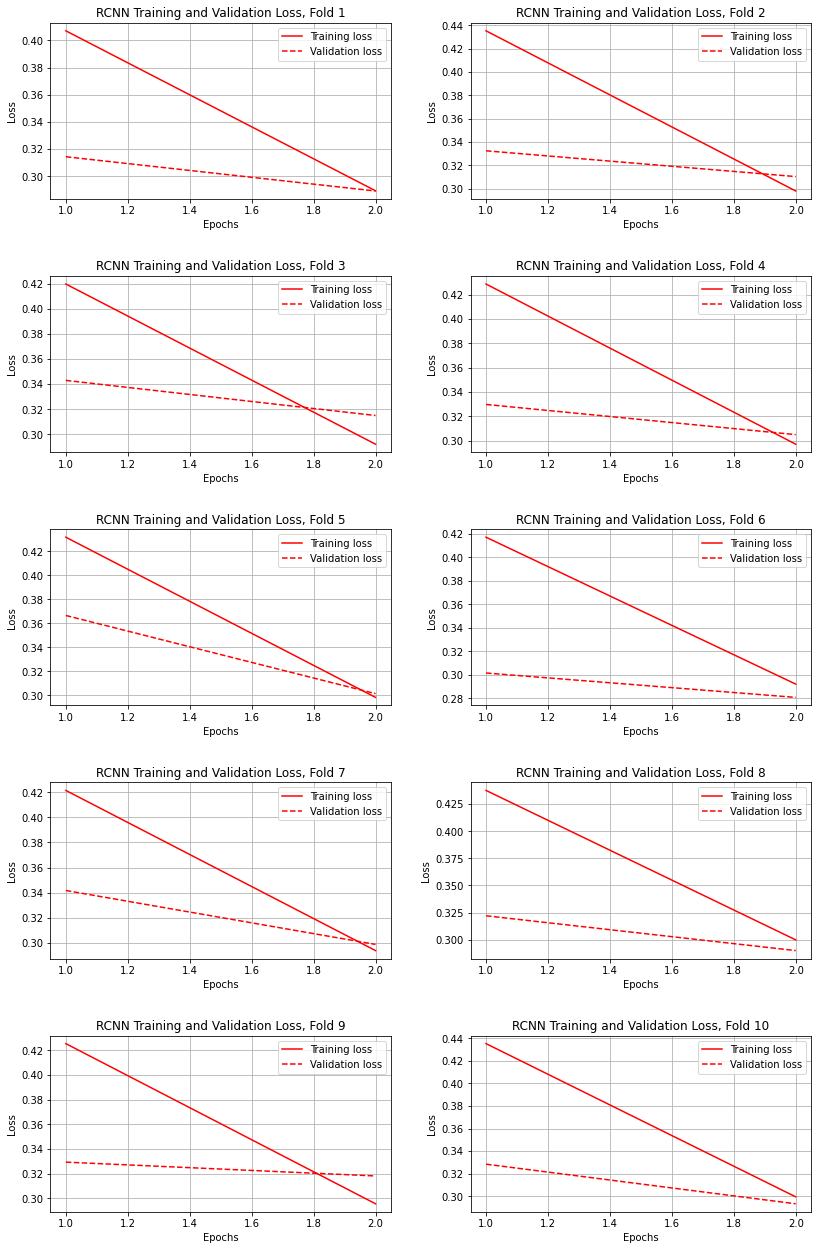

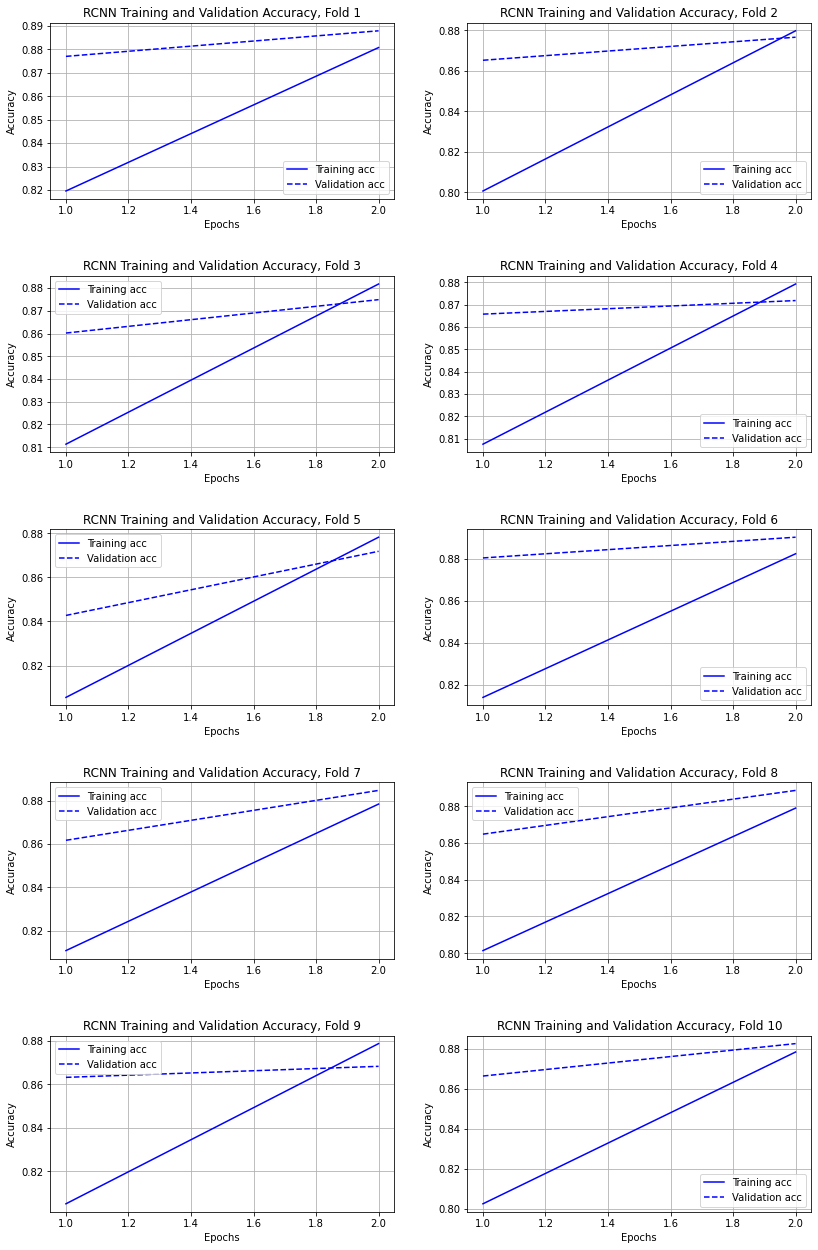

In [ ]:
import matplotlib.pyplot as plt

acc = []
val_acc = []
loss = []
val_loss = []

for i in range(len(results_history)):
  # history_dict = results_history[i].history
  history_dict = results_history[i]
  
  # print(history_dict.keys())

  acc.append(history_dict['accuracy'])
  val_acc.append(history_dict['val_accuracy'])
  loss.append(history_dict['loss'])
  val_loss.append(history_dict['val_loss'])
  


# # Loss Plot
epochs = range(1, len(acc[0]) + 1)
fig_row = -(-(len(acc)) // 2)
fig_col = 2
plt.rcParams['figure.figsize'] = [12, 18]
for i in range(len(loss)):
  plt.subplot(fig_row, fig_col, i+1)
  plt.plot(epochs, loss[i], 'r', label='Training loss')
  plt.plot(epochs, val_loss[i], 'r--', label='Validation loss')
  plt.title('RCNN Training and Validation Loss, Fold {}'.format(i+1))
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)
  # plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
  # plt.minorticks_on()
plt.tight_layout(pad=3.0)
plt.savefig("./rcnn/rcnn_loss_10fold.png", format='png', dpi=150, bbox_inches='tight')
plt.show()


# # Accuracy Plot
plt.clf()   # clear figure
for i in range(len(acc)):
  plt.subplot(fig_row, fig_col, i+1)
  plt.plot(epochs, acc[i], 'b', label='Training acc')
  plt.plot(epochs, val_acc[i], 'b--', label='Validation acc')
  plt.title('RCNN Training and Validation Accuracy, Fold {}'.format(i+1))
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.grid(True)
plt.tight_layout(pad=3.0)
plt.savefig("./rcnn/rcnn_accuracy_10fold.png", format='png', dpi=150, bbox_inches='tight')
plt.show()

Calculate Model Metrics
<br> Precision, Recall, Accuracy, F1-Score

In [ ]:
idx_best = 0
best_acc = 0

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Metrics Score per fold')
for i in range(0, len(all_accuracy)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1}')
  print('Accuracy: %f' % all_accuracy[i])
  print('Precision: %f' % all_precision[i])
  print('Recall: %f' % all_recall[i])
  print('F1 score: %f' % all_f1[i])
  if (all_accuracy[i] >= best_acc):
    idx_best = i
    best_acc = all_accuracy[i]
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Average Accuracy: {np.mean(np.asarray(all_accuracy))}')
print(f'> Average Precision: {np.mean(np.asarray(all_precision))}')
print(f'> Average Recall: {np.mean(np.asarray(all_recall))}')
print(f'> Average F1 Score: {np.mean(np.asarray(all_f1))}')
print('------------------------------------------------------------------------')
print('------------------------------------------------------------------------')



------------------------------------------------------------------------
Metrics Score per fold
------------------------------------------------------------------------
> Fold 1
Accuracy: 0.884868
Precision: 0.892777
Recall: 0.933150
F1 score: 0.912517
------------------------------------------------------------------------
> Fold 2
Accuracy: 0.875981
Precision: 0.896402
Recall: 0.908617
F1 score: 0.902468
------------------------------------------------------------------------
> Fold 3
Accuracy: 0.865604
Precision: 0.852105
Recall: 0.951768
F1 score: 0.899184
------------------------------------------------------------------------
> Fold 4
Accuracy: 0.886864
Precision: 0.882033
Recall: 0.952194
F1 score: 0.915772
------------------------------------------------------------------------
> Fold 5
Accuracy: 0.876740
Precision: 0.875902
Recall: 0.944380
F1 score: 0.908853
------------------------------------------------------------------------
> Fold 6
Accuracy: 0.889142
Precision: 0.90168

Plot Precision-Recall Curve

In [ ]:
# import matplotlib.pyplot as pltdf_prerec_unpickled = pd.read_pickle("./rcnn/rcnn_all_metrics_10fold.pkl")

# df_prerec_unpickled
# all_arr_precision = df_prerec_unpickled['all_arr_precision'].tolist()
# all_arr_recall = df_prerec_unpickled['all_arr_recall'].tolist()
# all_ave_precision = df_prerec_unpickled['all_ave_precision'].tolist()

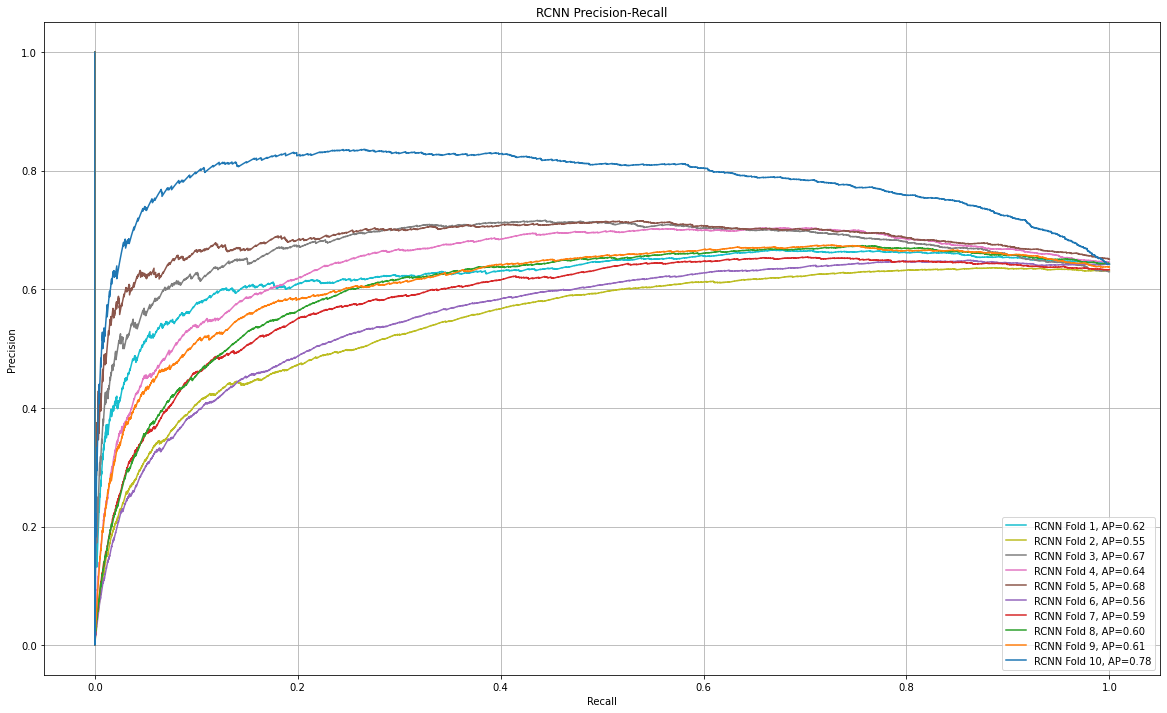

In [ ]:
import matplotlib.cm as cm

colors = cm.tab10_r(np.linspace(0, 1, len(all_arr_recall)))


plt.clf()   # clear figure
plt.rcParams['figure.figsize'] = [20, 12]

for i in range(len(all_arr_recall)):
  plt.plot(all_arr_recall[i], all_arr_precision[i], color=colors[i], label='RCNN Fold {}, AP={:0.2f}'.format(i+1, all_ave_precision[i]))
  # plt.plot(np.linspace(0, 1, thresholds[i].size), thresholds[i], linestyle='--', label='Threshold')
plt.title('RCNN Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc=4)
plt.grid(True)
# plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
# plt.minorticks_on()
plt.savefig("./rcnn/rcnn_10fold_precision_recall.png", format='png', dpi=150, bbox_inches='tight')
plt.show()


Draw Confusion Matrix

In [ ]:
# unique, counts = np.unique(y_test_conv, return_counts=True)
# print(dict(zip(unique, counts)))
# cf_matrix = confusion_matrix(y_test_conv, yhat_classes)
# cf_matrix_best = all_cf_matrices[idx_best]
# print(cf_matrix_best)

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

<Figure size 864x648 with 0 Axes>

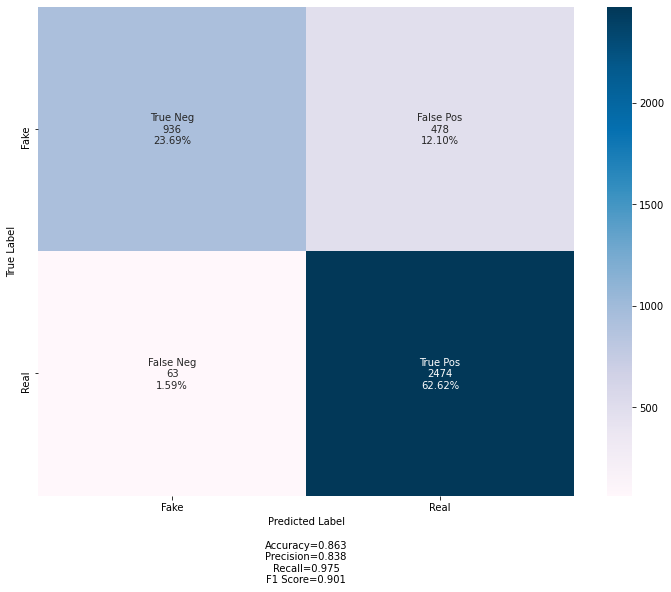

In [ ]:
import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 9]
for j in range(len(all_cf_matrices)):
  cf_matrix_best = all_cf_matrices[j]

  stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                  all_accuracy[j],all_precision[j],all_recall[j],all_f1[j])

  group_names = ['True Neg','False Pos','False Neg','True Pos']

  group_counts = ["{0:0.0f}".format(value) for value in
                  cf_matrix_best.flatten()]

  group_percentages = ["{0:.2%}".format(value) for value in
                      cf_matrix_best.flatten()/np.sum(cf_matrix_best)]

  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
            
  labels = np.asarray(labels).reshape(2,2)
  categories = ['Fake', 'Real']
  # cmap = sns.dark_palette("red")
  # cmap = sns.cubehelix_palette(8, start=.5, rot=-.75, as_cmap=True)
  # cmap = sns.color_palette("GnBu_d")

  plt.clf() 
  plt.figure()
  svm = sns.heatmap(cf_matrix_best, annot=labels, fmt='', cmap='PuBu',xticklabels=categories,yticklabels=categories)

  plt.ylabel('True Label')
  plt.xlabel('Predicted Label' + stats_text)

  # figure = svm.get_figure()    
  # figure.savefig('./rcnn/rcnn_conf_matrix.png', dpi=150)

  plt.savefig("./rcnn/cfpr/rcnn_best_10fold_conf_matrix_fold{}.png".format(j+1), format='png', dpi=150, bbox_inches='tight')

In [ ]:
for m in range(len(all_arr_precision)):
  df_prerec = pd.DataFrame(all_arr_precision[m])
  df_prerec.columns = ['precision']
  df_prerec['recall'] = all_arr_recall[m]
  df_prerec['threshold'] = all_thresholds[m]
  df_prerec
  df_prerec.to_pickle("./rcnn/cfpr/rcnn_best_10fold_precison_recall_curve_fold{}.pkl".format(m+1))

In [ ]:
!jupyter nbconvert --to html ./rcnn/rcnn_classification_malay_10fold.ipynb

[NbConvertApp] Converting notebook ./rcnn/rcnn_classification_malay_10fold.ipynb to html
[NbConvertApp] Writing 982094 bytes to ./rcnn/rcnn_classification_malay_10fold.html
